In [1]:
import pandas as pd
import numpy as np
import shap
shap.initjs()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
%matplotlib inline
plt.style.use("ggplot")

Business Problem: Can we predict the following individuals of being a low or high risk for their loan?

In [2]:
# Read in data
df = pd.read_csv('NMLoanDefault.csv')
df = df.rename(columns = {'Unnamed: 0' : 'pkey'})
listy = df.columns.tolist()
listy = [x.lower() for x in listy]
df.columns = listy
print(df.shape)

(5960, 14)


In [3]:
df.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,reason_cde,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,job_cde,delingq_cnt
0,0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0
1,1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0
2,2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0
3,3,68500.0,0,42.0,0.0,NaN,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0
4,4,55500.0,0,11.0,0.0,NaN,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0


# 1) Perform EDA to look at the data before data cleaning

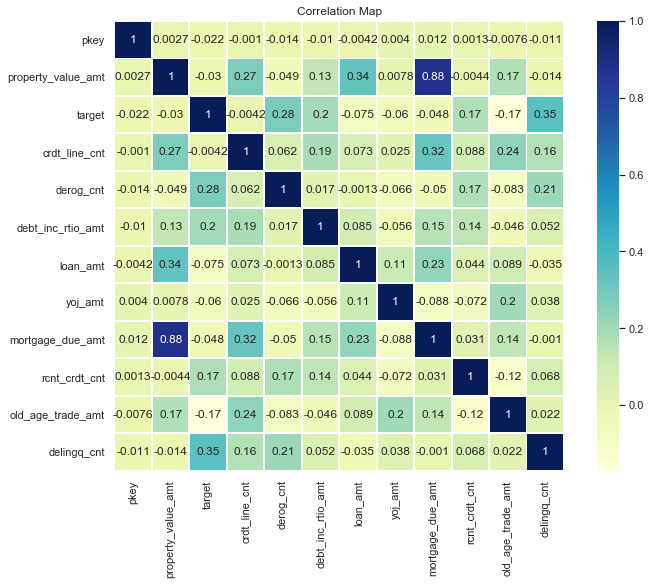

In [109]:
## Take a look at the correlation of the numerical fields

sns.heatmap(df.corr() , square = True , annot = True, linewidths = .8 , cmap = 'YlGnBu')
plt.title("Correlation Map")
plt.show()

Some noticable variable correlation are as follows:
derog_cnt vs target
delingq_cnt vs target
crd_line_cnt vs property_value_amt
and etc.

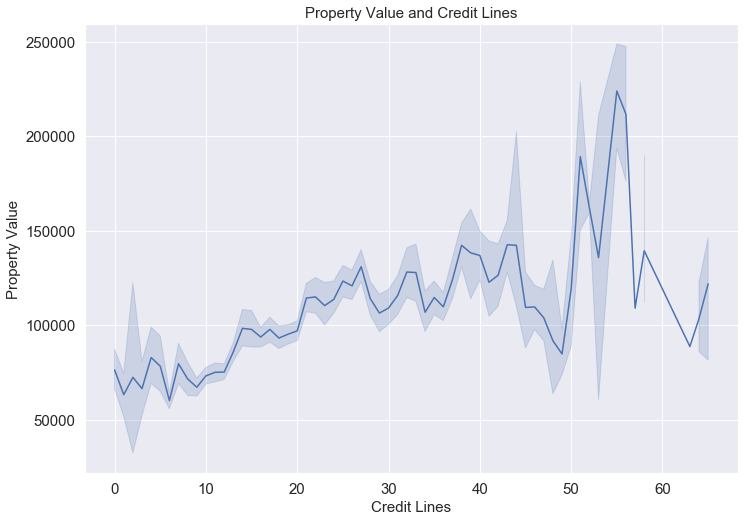

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)});
sns.lineplot(data = df , x = "crdt_line_cnt", y = "property_value_amt", markers = True , dashes = True);
plt.figsize = (20,7);
plt.title('Property Value and Credit Lines' , size = 15);
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlabel("Credit Lines" , size = 15);
plt.ylabel("Property Value" , size = 15);

We can see there is a positive trend towards the number of credit lines and the property value. So there is a positive correlation between credit lines and property value.

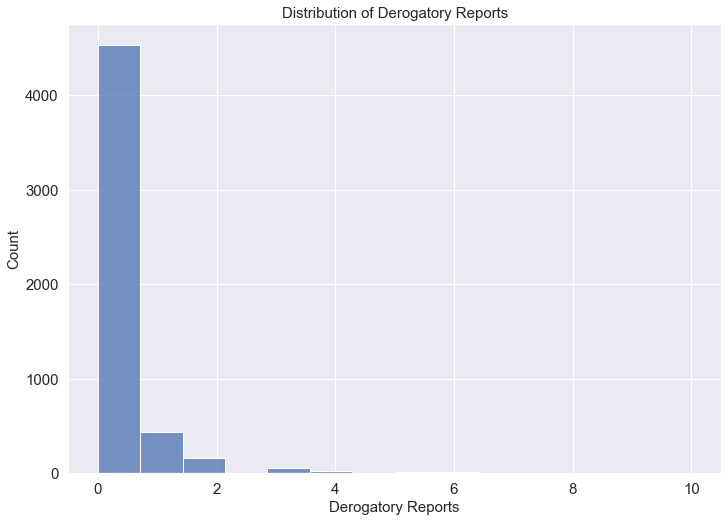

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)});
sns.histplot(data = df , x = "derog_cnt");
plt.figsize = (20,7);
plt.title('Distribution of Derogatory Reports' , size = 15);
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlabel("Derogatory Reports" , size = 15);
plt.ylabel("Count" , size = 15);

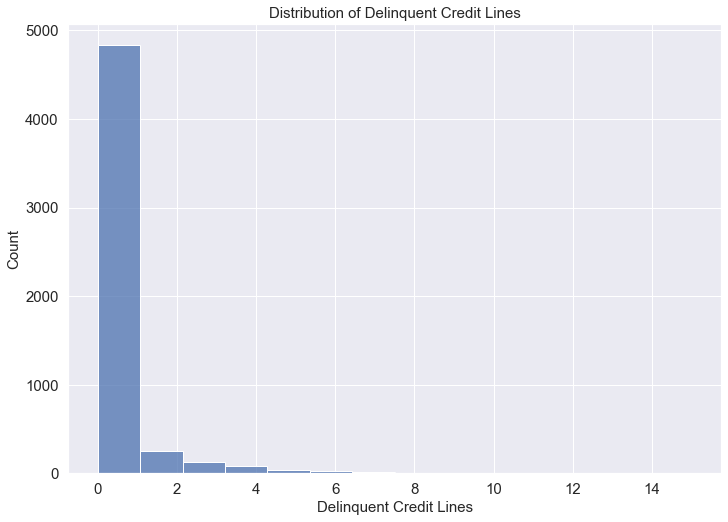

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)});
sns.histplot(data = df , x = "delingq_cnt");
plt.figsize = (20,7);
plt.title('Distribution of Delinquent Credit Lines' , size = 15);
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlabel("Delinquent Credit Lines" , size = 15);
plt.ylabel("Count" , size = 15);

For dergotary reports and delinquent lines, is it a 1:1 ratio for those with 0 dg reports and dl lines?

In [8]:
zero = df[np.logical_and(df.delingq_cnt == 0 , df.derog_cnt == 0)]

In [9]:
(zero.shape[0]/df.shape[0])*100

62.93624161073825

63% of the population are in excellent standing, where they have 0 delinquent lines and 0 dergotary reports. So my intuition is telling me that before even running the model that we should get a good population of the people at low risk.

In [10]:
def eda_boxplots(x):
    for n in x:
        if df[n].dtype == 'float64':
            sns.boxplot(df[n]);
        plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


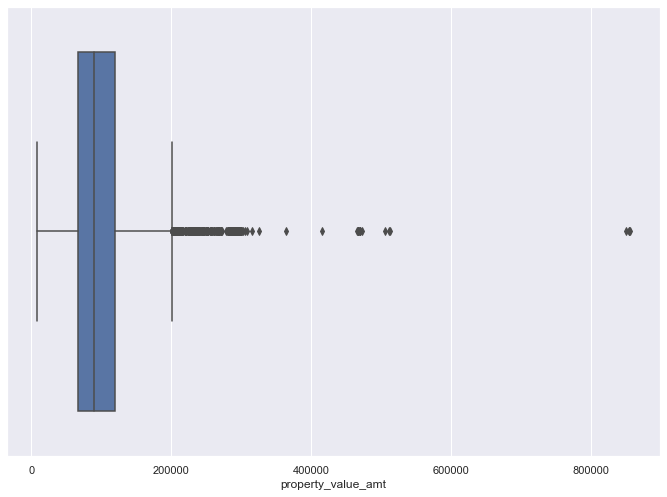

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


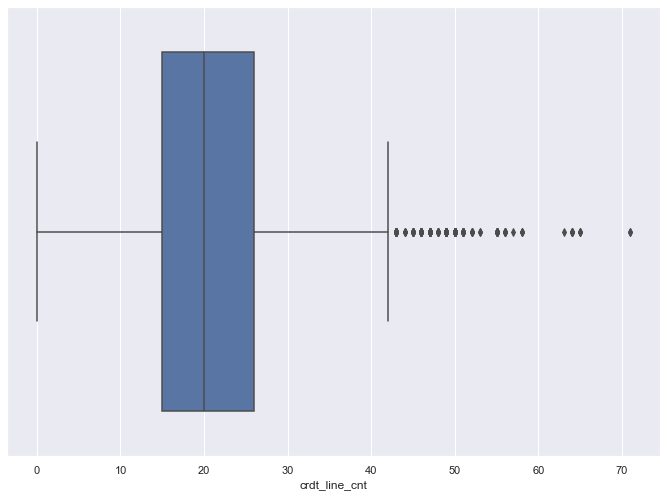

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


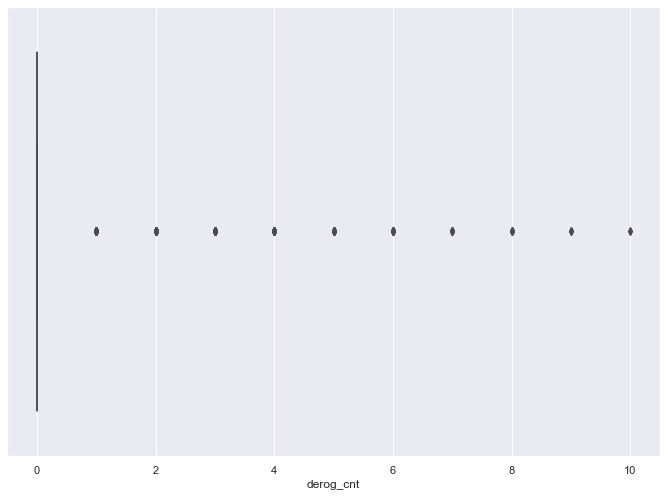

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


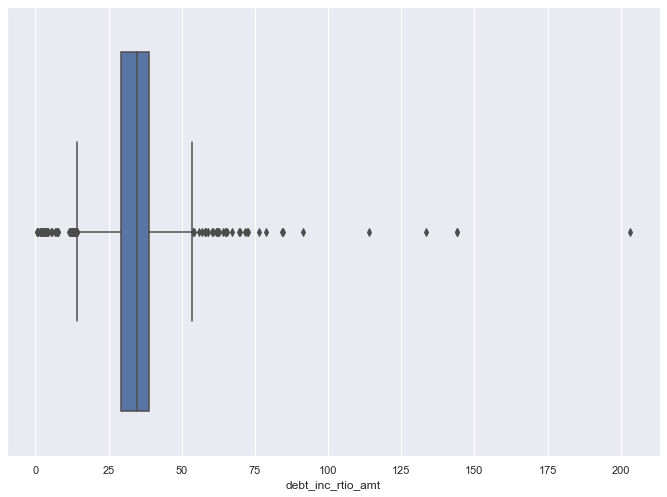

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


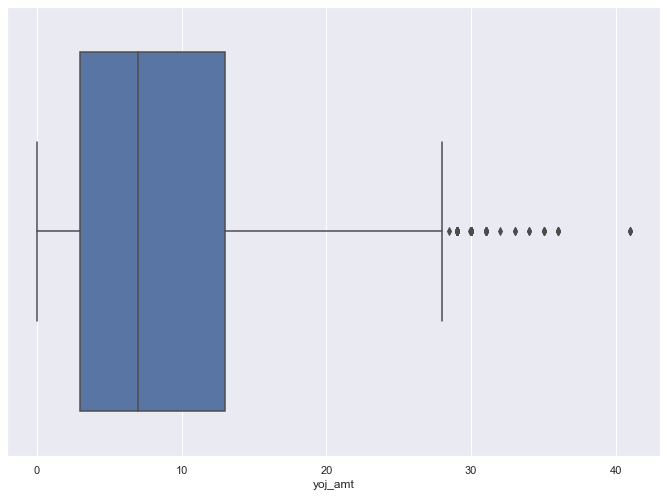

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


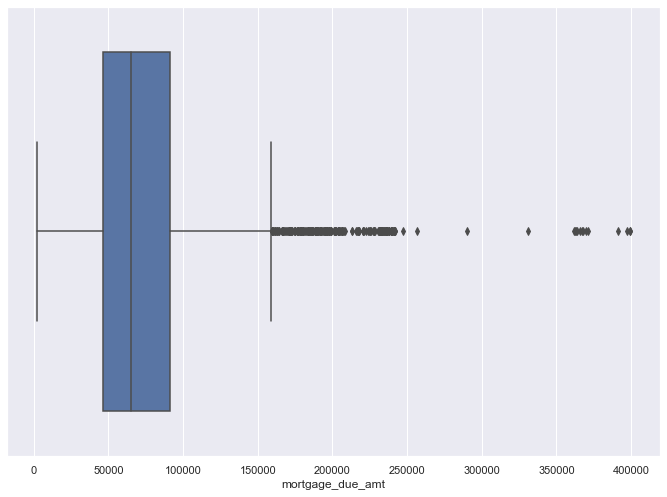

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


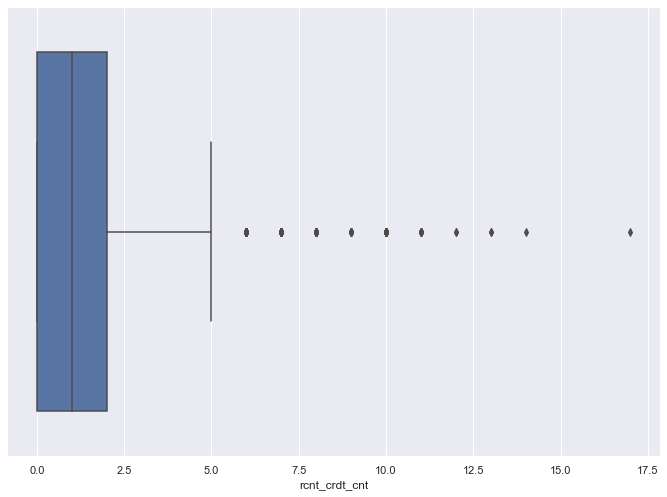

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


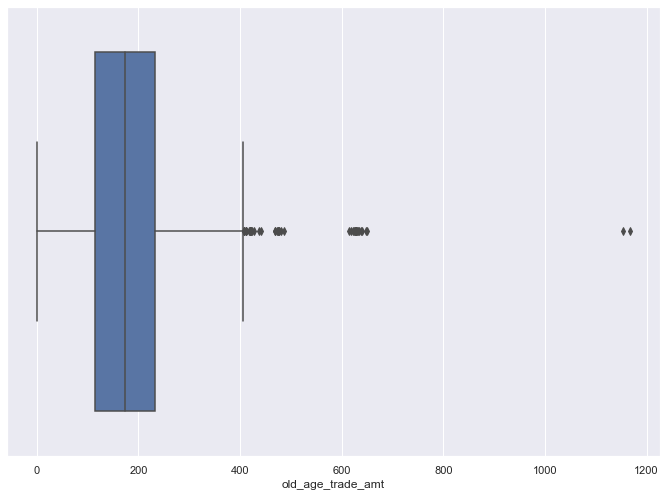

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


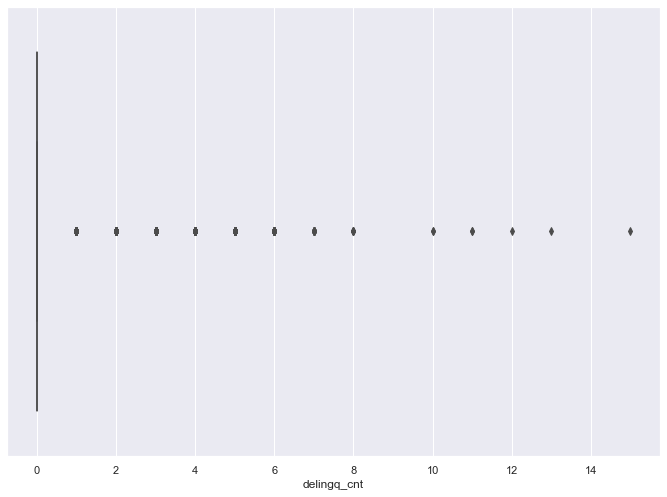

In [11]:
eda_boxplots(df.columns.tolist())

# 2) Data Cleaning

In [12]:
# Dealing with missing values

In [13]:
df1 = df.copy()

In [14]:
# Creating a dataframe to look at the percentages of missing values
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,1.88
2,target,0.00
3,crdt_line_cnt,3.72
4,derog_cnt,11.88
5,debt_inc_rtio_amt,21.26
6,loan_amt,0.00
7,reason_cde,4.23
8,yoj_amt,8.64
9,mortgage_due_amt,8.69


### 2.1) Property Value

In [16]:
df1.property_value_amt.describe()

count      5848.000000
mean     101776.048741
std       57385.775334
min        8000.000000
25%       66075.500000
50%       89235.500000
75%      119824.250000
max      855909.000000
Name: property_value_amt, dtype: float64

In [17]:
df1[df1.property_value_amt > 119824].shape[0] / df1.shape[0]

0.2453020134228188

In [18]:
#Almost 25% of property value amount are outliers, so we will use the median to substitute for these missing values

df1.property_value_amt = df1.property_value_amt.fillna(np.median(df.property_value_amt.dropna()))

In [19]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,3.72
4,derog_cnt,11.88
5,debt_inc_rtio_amt,21.26
6,loan_amt,0.00
7,reason_cde,4.23
8,yoj_amt,8.64
9,mortgage_due_amt,8.69


### 2.2) Credit Line Count

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


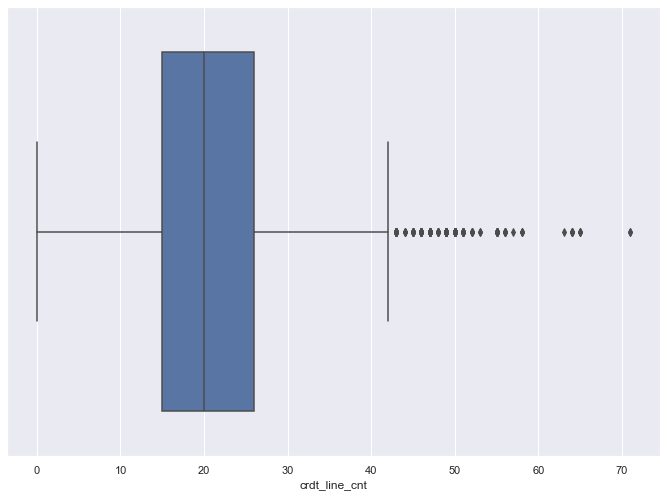

In [20]:
sns.boxplot(df1.crdt_line_cnt);

In [21]:
df1.crdt_line_cnt.describe()

count    5738.000000
mean       21.296096
std        10.138933
min         0.000000
25%        15.000000
50%        20.000000
75%        26.000000
max        71.000000
Name: crdt_line_cnt, dtype: float64

In [22]:
# the mean and median are nearly the same so going with either is fine
df1.crdt_line_cnt = df1.crdt_line_cnt.fillna(21)

### 2.3) Derogatory reports

In [23]:
df1.derog_cnt.describe()

count    5252.000000
mean        0.254570
std         0.846047
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: derog_cnt, dtype: float64

In [24]:
# Since the mode of this is 0 I will replace the missing values with 0
df1.derog_cnt = df1.derog_cnt.fillna(0)

In [25]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,21.26
6,loan_amt,0.00
7,reason_cde,4.23
8,yoj_amt,8.64
9,mortgage_due_amt,8.69


### 2.4) Debt Income Ratio Amount

In [26]:
df1.debt_inc_rtio_amt.describe()

count    4693.000000
mean       33.779915
std         8.601746
min         0.524499
25%        29.140031
50%        34.818262
75%        39.003141
max       203.312149
Name: debt_inc_rtio_amt, dtype: float64

In [27]:
df1.debt_inc_rtio_amt = df1.debt_inc_rtio_amt.fillna(np.median(df1.debt_inc_rtio_amt.dropna()))

### 2.5) Reason Code

In [28]:
df1.reason_cde.value_counts()

DebtCon    3928
HomeImp    1780
Name: reason_cde, dtype: int64

In [29]:
df1.reason_cde.isnull().sum()

252

In [30]:
## We can use the mode for this, since DebtCon is about a 2:1 ratio
df1.reason_cde = df1.reason_cde.fillna('DebtCon')

In [31]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,0.00
6,loan_amt,0.00
7,reason_cde,0.00
8,yoj_amt,8.64
9,mortgage_due_amt,8.69


### 2.6) Years at present job

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


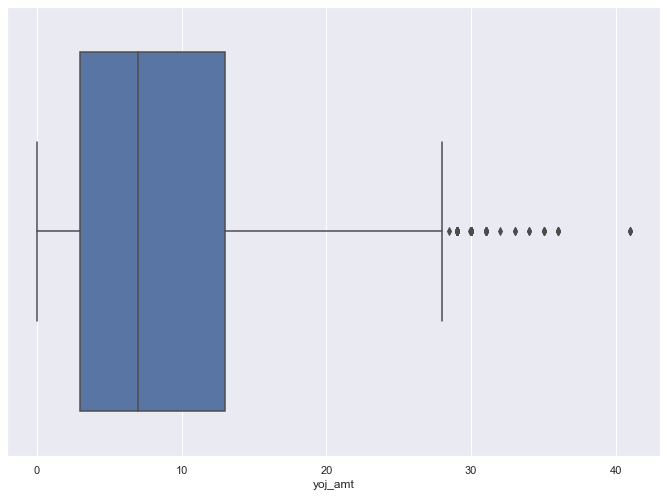

In [32]:
sns.boxplot(df1.yoj_amt);

In [33]:
df1.yoj_amt.describe()

count    5445.000000
mean        8.922268
std         7.573982
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        41.000000
Name: yoj_amt, dtype: float64

In [34]:
df1[df1.yoj_amt > 13].shape[0] / df1.shape[0]

0.2162751677852349

In [35]:
# I will be using median as the value to replace the missing values for this field

df1.yoj_amt = df1.yoj_amt.fillna(np.median(df1.yoj_amt.dropna()))

In [36]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,0.00
6,loan_amt,0.00
7,reason_cde,0.00
8,yoj_amt,0.00
9,mortgage_due_amt,8.69


### 2.7) Mortgage Due Amount

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


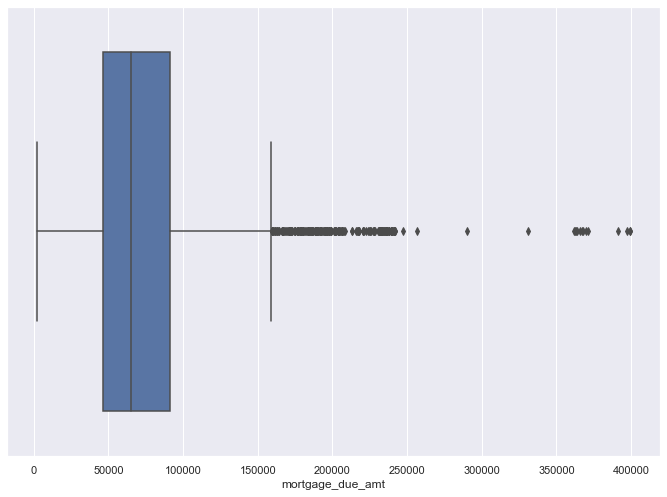

In [37]:
sns.boxplot(df1.mortgage_due_amt);

In [38]:
df1.mortgage_due_amt.describe()

count      5442.000000
mean      73760.817200
std       44457.609458
min        2063.000000
25%       46276.000000
50%       65019.000000
75%       91488.000000
max      399550.000000
Name: mortgage_due_amt, dtype: float64

In [39]:
df1[df1.mortgage_due_amt > 91488].shape[0] / df1.shape[0]

0.22835570469798658

In [40]:
# I will be using median as the value to replace the missing values for this field

df1.mortgage_due_amt = df1.mortgage_due_amt.fillna(np.median(df1.mortgage_due_amt.dropna()))

In [41]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,0.00
6,loan_amt,0.00
7,reason_cde,0.00
8,yoj_amt,0.00
9,mortgage_due_amt,0.00


### 2.8) Recent Credit Lines

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


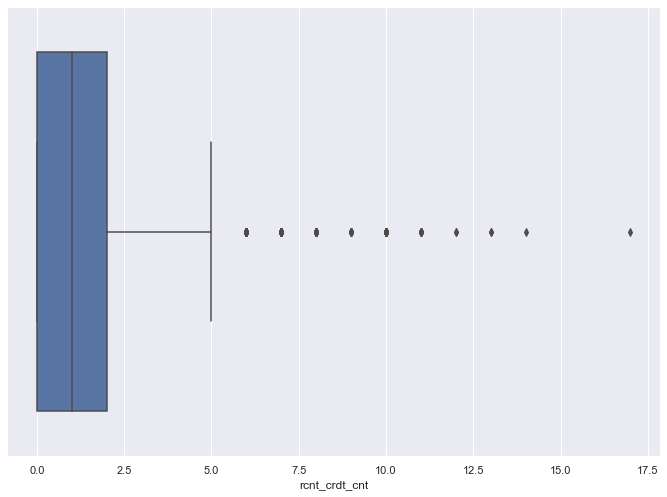

In [42]:
sns.boxplot(df1.rcnt_crdt_cnt);

In [43]:
df1.rcnt_crdt_cnt.describe()

count    5450.000000
mean        1.186055
std         1.728675
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: rcnt_crdt_cnt, dtype: float64

In [44]:
df1.rcnt_crdt_cnt = df1.rcnt_crdt_cnt.fillna(1)

In [45]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,0.00
6,loan_amt,0.00
7,reason_cde,0.00
8,yoj_amt,0.00
9,mortgage_due_amt,0.00


### 2.9) Oldest Trade Line

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


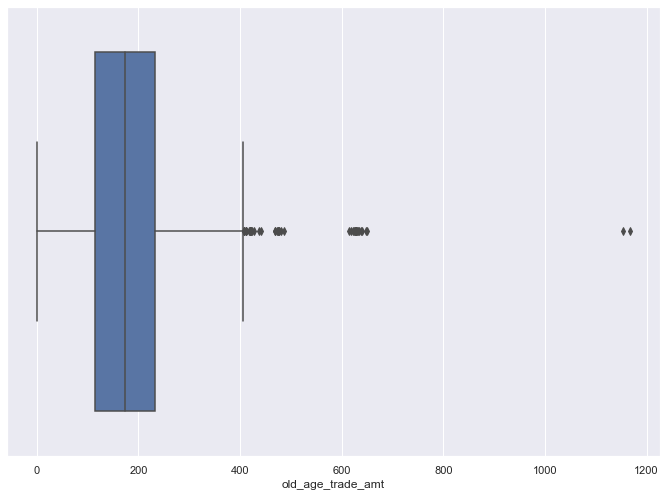

In [46]:
sns.boxplot(df1.old_age_trade_amt);

In [47]:
df1.old_age_trade_amt.describe()

count    5652.000000
mean      179.766275
std        85.810092
min         0.000000
25%       115.116702
50%       173.466667
75%       231.562278
max      1168.233561
Name: old_age_trade_amt, dtype: float64

In [48]:
df1[df1.old_age_trade_amt > 231.562278].shape[0] / df1.shape[0]

0.2370805369127517

In [49]:
df1.old_age_trade_amt = df1.old_age_trade_amt.fillna(np.median(df1.old_age_trade_amt.dropna()))

In [50]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.00
1,property_value_amt,0.00
2,target,0.00
3,crdt_line_cnt,0.00
4,derog_cnt,0.00
5,debt_inc_rtio_amt,0.00
6,loan_amt,0.00
7,reason_cde,0.00
8,yoj_amt,0.00
9,mortgage_due_amt,0.00


### 2.10) Job Code

In [51]:
df1.job_cde.value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: job_cde, dtype: int64

In [52]:
df1.job_cde = df1.job_cde.fillna('Other')

### 2.11) Delinquent Credit Lines

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


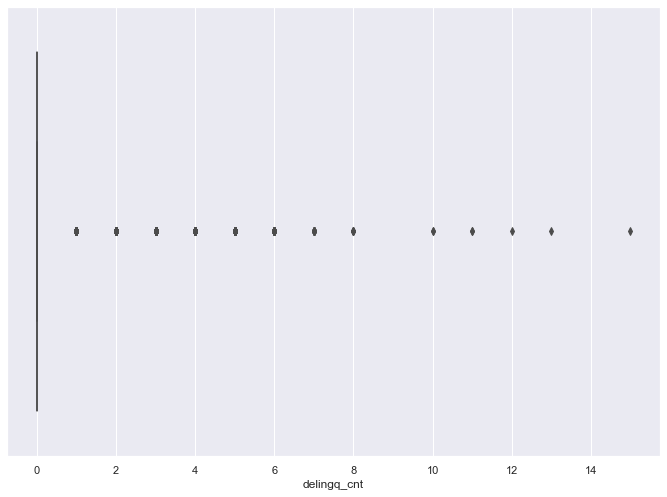

In [53]:
sns.boxplot(df1.delingq_cnt);

In [54]:
df1.delingq_cnt.describe()

count    5380.000000
mean        0.449442
std         1.127266
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.000000
Name: delingq_cnt, dtype: float64

In [55]:
df1.delingq_cnt = df1.delingq_cnt.fillna(0)

In [56]:
dictionary = {}
for n in df1.columns.tolist():
    dictionary[n] = np.round((df1[n].isnull().sum()/df1.shape[0]) * 100,2)
    missing_values = pd.DataFrame(list(dictionary.items()), columns = ['field' , 'missing_%'])
missing_values

,field,missing_%
0,pkey,0.0
1,property_value_amt,0.0
2,target,0.0
3,crdt_line_cnt,0.0
4,derog_cnt,0.0
5,debt_inc_rtio_amt,0.0
6,loan_amt,0.0
7,reason_cde,0.0
8,yoj_amt,0.0
9,mortgage_due_amt,0.0


# 3) One Hot Encodings, Rebalancing and Normalizing

### 3.1) Feature Engineering

In [57]:
df1.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,reason_cde,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,job_cde,delingq_cnt
0,0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0
1,1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0
2,2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0
3,3,68500.0,0,42.0,0.0,34.818262,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0
4,4,55500.0,0,11.0,0.0,34.818262,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0


In [58]:
df1['standing_num'] = df1.derog_cnt + df1.delingq_cnt
df1.loc[df1['standing_num'] == 0, 'standing_value'] = 'Excellent'
df1.loc[np.logical_and(df1['standing_num'] > 0,df1['standing_num'] <= 3 ), 'standing_value'] = 'Good'
df1.loc[np.logical_and(df1['standing_num'] > 3,df1['standing_num'] <= 7 ), 'standing_value'] = 'Fair'
df1.loc[df1['standing_num'] > 7, 'standing_value'] = 'Questionable'

'''
This column takes the sum of delinquent counts and derogatory reports and returns a general idea 
of their credit standing
'''

'\nThis column takes the sum of delinquent counts and derogatory reports and returns a general idea \nof their credit standing\n'

In [59]:
df1['total_debt'] = df1.loan_amt + df1.mortgage_due_amt
df1['monthly_debt'] = np.round((df1['total_debt']/df1.yoj_amt.replace(0,1))/12,2)
## there are some people with 0 as total years at job, replacing it with 1 will remove inf values
df1['yearly_income'] = np.round((df1['monthly_debt']/(df1.debt_inc_rtio_amt/100))*12,0)

'''
This feature eng. is to find the total, monthly and yearly income for these people.
This is not an exact science of finding a yearly salary, there are some outliers that seem
unrealistic. However, since I will normalize the data by taking the log of these fields, it
wont affect the model too much.
'''

'\nThis feature eng. is to find the total, monthly and yearly income for these people.\nThis is not an exact science of finding a yearly salary, there are some outliers that seem\nunrealistic. However, since I will normalize the data by taking the log of these fields, it\nwont affect the model too much.\n'

In [60]:
df1.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,reason_cde,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,job_cde,delingq_cnt,standing_num,standing_value,total_debt,monthly_debt,yearly_income
0,0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0,0.0,Excellent,48440.0,403.67,16036.0
1,1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0,0.0,Excellent,85282.0,1015.26,27868.0
2,2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0,0.0,Excellent,223125.0,2324.22,67569.0
3,3,68500.0,0,42.0,0.0,34.818262,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0,0.0,Excellent,63000.0,525.00,18094.0
4,4,55500.0,0,11.0,0.0,34.818262,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0,0.0,Excellent,49726.0,690.64,23803.0


In [61]:
## Save copy of this data set for when we do clustering

df_clustering = df1.copy()

### 3.2) One Hot Encodings

In [62]:
# Need to change two variables: reason_cde and job_cde into one hot encodings since they are categorical variables

df1.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,reason_cde,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,job_cde,delingq_cnt,standing_num,standing_value,total_debt,monthly_debt,yearly_income
0,0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0,0.0,Excellent,48440.0,403.67,16036.0
1,1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0,0.0,Excellent,85282.0,1015.26,27868.0
2,2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0,0.0,Excellent,223125.0,2324.22,67569.0
3,3,68500.0,0,42.0,0.0,34.818262,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0,0.0,Excellent,63000.0,525.00,18094.0
4,4,55500.0,0,11.0,0.0,34.818262,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0,0.0,Excellent,49726.0,690.64,23803.0


In [63]:
df2 = pd.get_dummies(df1)

In [64]:
df2.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable
0,0,91704.0,0,20.0,0.0,30.206893,20000,10.0,28440.0,0.0,143.637439,0.0,0.0,48440.0,403.67,16036.0,1,0,0,0,0,1,0,0,1,0,0,0
1,1,88342.0,0,11.0,0.0,43.717635,4800,7.0,80482.0,0.0,275.032395,0.0,0.0,85282.0,1015.26,27868.0,0,1,0,0,0,1,0,0,1,0,0,0
2,2,242602.0,0,26.0,0.0,41.277127,25700,8.0,197425.0,2.0,102.960346,0.0,0.0,223125.0,2324.22,67569.0,1,0,0,0,1,0,0,0,1,0,0,0
3,3,68500.0,0,42.0,0.0,34.818262,18000,10.0,45000.0,1.0,190.800000,0.0,0.0,63000.0,525.00,18094.0,1,0,0,0,0,1,0,0,1,0,0,0
4,4,55500.0,0,11.0,0.0,34.818262,8600,6.0,41126.0,1.0,73.033333,0.0,0.0,49726.0,690.64,23803.0,1,0,0,0,1,0,0,0,1,0,0,0


### 3.4) Normalizing

In [65]:
for n in ['property_value_amt' , 'loan_amt' , 'mortgage_due_amt' , 'debt_inc_rtio_amt' , 'old_age_trade_amt',
         'total_debt','monthly_debt', 'yearly_income']:
    df2[n] = df2[n].apply(lambda i: math.log(i+1))
## adding one to each value to get rid of 0 values for the log

# 4) EDA Part 2: Clustering

### 4.1) Clustering

Clustering is a great method to understand the similarities and differences between groups and works well for EDA's.

In [66]:
from sklearn.cluster import KMeans
import pandas as pd
df2 = df2.set_index('pkey')
target = df2['target'].values
X = df2.drop('target',axis = 1).values

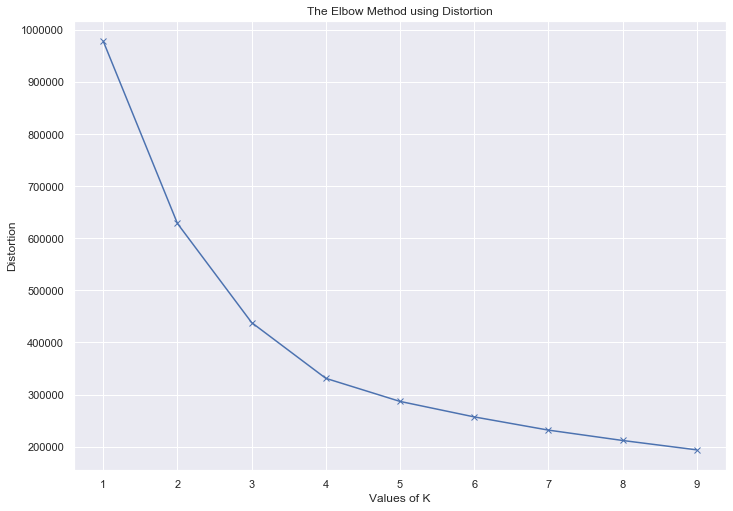

In [68]:
## Finding the optimal number of clusters using elbow method

distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df2)
    distortions.append(km.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

## The elbow curve shows that the 4 clusters are the best number for our model.

In [69]:
# Using PCA to minimize the dataset to two columns for when we plot our predicted labels

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
principalComponents2 = pca.fit_transform(X)
PCA_components2 = pd.DataFrame(principalComponents2)
PCA_components2.head()

,0,1
0,-1.284021,1.562142
1,-10.378929,-1.171411
2,4.707929,-1.139078
3,20.692244,0.495585
4,-10.466865,-2.105476


In [71]:
## Fitting KMeans clustering

km = KMeans(n_clusters = 4, random_state = 43)
km.fit(PCA_components2)
labels = km.predict(PCA_components2)
centroids = km.cluster_centers_

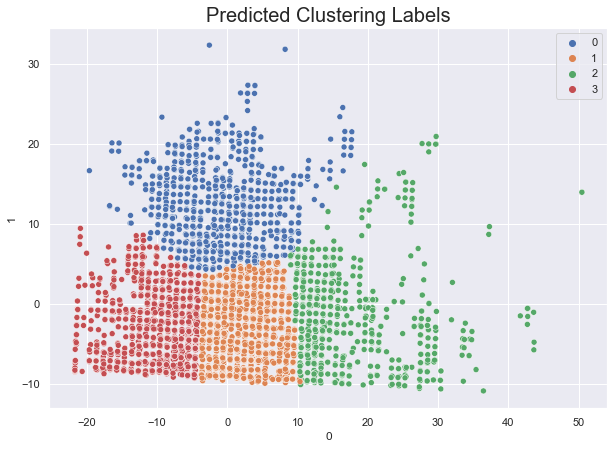

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sns.scatterplot(data = PCA_components2 , x = PCA_components2.iloc[:,0] ,y = PCA_components2.iloc[:,1], hue= labels,
               palette="deep");
plt.title('Predicted Clustering Labels', size = 20)
plt.show()

### 4.2) Clustering Analysis

In [73]:
cluster_ = pd.concat([pd.DataFrame(labels, columns = {'cluster_label'}), df_clustering], axis = 1)

In [74]:
cluster_.head()

,cluster_label,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,reason_cde,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,job_cde,delingq_cnt,standing_num,standing_value,total_debt,monthly_debt,yearly_income
0,1,0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0,0.0,Excellent,48440.0,403.67,16036.0
1,3,1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0,0.0,Excellent,85282.0,1015.26,27868.0
2,1,2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0,0.0,Excellent,223125.0,2324.22,67569.0
3,2,3,68500.0,0,42.0,0.0,34.818262,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0,0.0,Excellent,63000.0,525.00,18094.0
4,3,4,55500.0,0,11.0,0.0,34.818262,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0,0.0,Excellent,49726.0,690.64,23803.0


In [75]:
zero = cluster_[cluster_['cluster_label'] == 0]
one = cluster_[cluster_['cluster_label'] == 1]
two = cluster_[cluster_['cluster_label'] == 2]
three = cluster_[cluster_['cluster_label'] == 3]

In [76]:
zero.shape , one.shape , two.shape , three.shape

((1114, 20), (2264, 20), (837, 20), (1745, 20))

In [77]:
zero.describe().columns

Index(['cluster_label', 'pkey', 'property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income'],
      dtype='object')

In [78]:
zero[['property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income']].describe()

,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income
count,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,101447.266894,0.157092,19.813285,0.131957,33.313476,20365.439856,20.709425,64753.407118,0.998205,207.635471,0.479354,0.611311,85118.846975,364.642899,13688.507181
std,67607.127122,0.364051,6.151221,0.530814,6.630487,13281.618919,4.984123,38730.139473,1.674822,88.322076,1.207950,1.420773,42152.924014,203.899095,10795.726721
min,16020.000000,0.000000,1.000000,0.000000,0.524499,2000.000000,12.600000,4734.000000,0.000000,9.100000,0.000000,0.000000,10600.000000,28.490000,982.000000
25%,64796.250000,0.000000,16.000000,0.000000,29.532513,11900.000000,17.000000,39870.250000,0.000000,147.554299,0.000000,0.000000,57532.500000,220.265000,8057.500000
50%,89235.500000,0.000000,20.000000,0.000000,34.818262,18000.000000,20.000000,58518.500000,0.000000,198.766860,0.000000,0.000000,76505.000000,322.535000,12094.500000
75%,116427.250000,0.000000,24.000000,0.000000,37.322563,25100.000000,24.000000,85549.000000,1.000000,248.819509,0.000000,1.000000,103695.750000,458.060000,17230.000000
max,855909.000000,1.000000,38.000000,8.000000,84.613889,89900.000000,41.000000,331000.000000,11.000000,649.747104,13.000000,13.000000,371000.000000,1469.760000,251280.000000


In [79]:
one[['property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income']].describe()

,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income
count,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,106823.561122,0.184629,23.061396,0.265901,34.276485,18561.130742,5.641409,78137.384779,1.242491,171.436429,0.353357,0.619258,96698.515521,3116.592151,1.126734e+05
std,51725.092661,0.388082,3.524704,0.865688,8.167778,10564.335643,3.676204,41098.421118,1.631803,66.879336,0.958557,1.414182,44819.754720,6304.195455,2.876260e+05
min,12500.000000,0.000000,18.000000,0.000000,3.016141,1500.000000,0.000000,4447.000000,0.000000,32.414934,0.000000,0.000000,12768.000000,97.250000,3.352000e+03
25%,74296.250000,0.000000,20.000000,0.000000,31.359956,11100.000000,2.000000,54077.000000,0.000000,120.419800,0.000000,0.000000,70015.250000,869.572500,3.089650e+04
50%,94783.000000,0.000000,22.000000,0.000000,34.818262,16800.000000,6.000000,69000.000000,1.000000,171.603150,0.000000,0.000000,87768.500000,1348.145000,5.143200e+04
75%,122612.500000,0.000000,26.000000,0.000000,37.992750,23300.000000,8.000000,93293.750000,2.000000,208.543942,0.000000,1.000000,113254.500000,3358.937500,1.196542e+05
max,512650.000000,1.000000,32.000000,9.000000,203.312149,76500.000000,14.000000,399550.000000,17.000000,412.020547,8.000000,13.000000,438412.000000,148046.670000,9.170519e+06


In [80]:
two[['property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income']].describe()

,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,8.370000e+02
mean,122063.844683,0.234170,38.989247,0.255675,36.009785,19843.966547,7.985066,95897.677419,1.402628,210.264534,0.708483,0.964158,115741.643967,3150.747921,1.091098e+05
std,54614.006166,0.423732,7.267357,0.915892,7.314846,10455.296844,5.983710,50196.094005,1.503311,82.664666,1.520541,1.929042,54950.993313,6554.039518,2.260125e+05
min,21500.000000,0.000000,30.000000,0.000000,16.378413,2800.000000,0.000000,6000.000000,0.000000,5.243341,0.000000,0.000000,11000.000000,117.510000,4.050000e+03
25%,82218.000000,0.000000,34.000000,0.000000,33.855895,12000.000000,3.000000,61429.000000,0.000000,152.249875,0.000000,0.000000,75614.000000,678.950000,2.219200e+04
50%,109800.000000,0.000000,36.000000,0.000000,34.818262,17000.000000,7.000000,82036.000000,1.000000,205.218329,0.000000,0.000000,101530.000000,1239.200000,4.098400e+04
75%,148695.000000,0.000000,43.000000,0.000000,39.945054,25700.000000,11.000000,120137.000000,2.000000,254.019689,1.000000,1.000000,145000.000000,3195.510000,1.175610e+05
max,364000.000000,1.000000,71.000000,8.000000,133.528270,56800.000000,31.000000,290000.000000,11.000000,485.945358,15.000000,17.000000,328000.000000,105833.330000,3.647511e+06


In [81]:
three[['property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income']].describe()

,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1.745000e+03
mean,84901.130854,0.229226,11.428080,0.214327,33.117775,16953.925501,5.536275,60619.781393,1.074499,157.041442,0.281375,0.495702,77573.706894,2451.910493,1.265088e+05
std,52122.080097,0.420456,4.411543,0.784688,7.502527,10674.341600,3.872046,36708.126991,1.719477,90.878556,0.825637,1.194938,39952.424422,4282.879308,4.836642e+05
min,8000.000000,0.000000,0.000000,0.000000,0.720295,1100.000000,0.000000,2063.000000,0.000000,0.000000,0.000000,0.000000,6800.000000,35.420000,1.221000e+03
25%,54138.000000,0.000000,9.000000,0.000000,29.646666,10200.000000,2.000000,39600.000000,0.000000,92.132908,0.000000,0.000000,57356.000000,739.860000,2.679800e+04
50%,73266.000000,0.000000,12.000000,0.000000,34.818262,15000.000000,5.000000,60890.000000,1.000000,131.705715,0.000000,0.000000,72900.000000,1158.040000,4.408700e+04
75%,96691.000000,0.000000,15.000000,0.000000,37.099533,20200.000000,8.000000,68830.000000,1.000000,204.095870,0.000000,0.000000,88687.000000,2741.040000,9.767700e+04
max,471827.000000,1.000000,17.000000,10.000000,72.670433,77400.000000,17.000000,371003.000000,14.000000,1168.233561,11.000000,11.000000,411703.000000,72266.670000,1.070658e+07


In [82]:
def eda_boxplots():
    for n in ['property_value_amt', 'target',
       'crdt_line_cnt', 'derog_cnt', 'debt_inc_rtio_amt', 'loan_amt',
       'yoj_amt', 'mortgage_due_amt', 'rcnt_crdt_cnt', 'old_age_trade_amt',
       'delingq_cnt', 'standing_num', 'total_debt', 'monthly_debt',
       'yearly_income']:
        sns.boxplot(x = 'cluster_label' , y= n ,data = cluster_);
        plt.show()

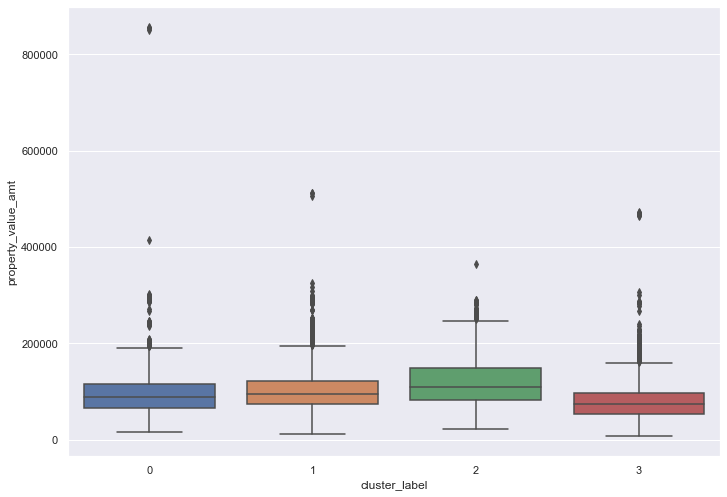

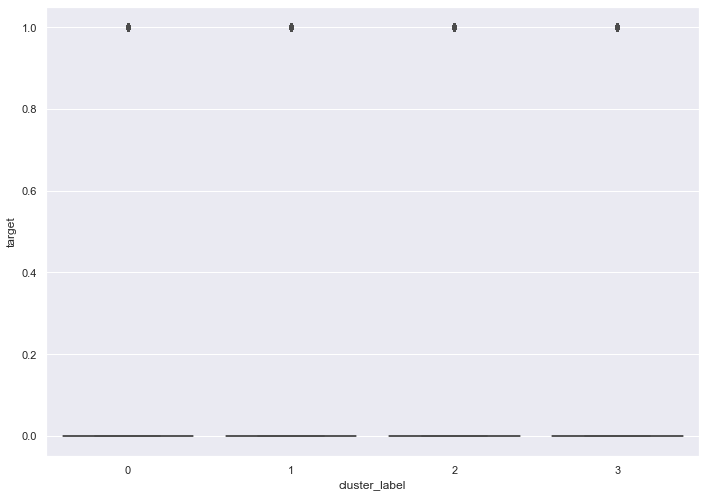

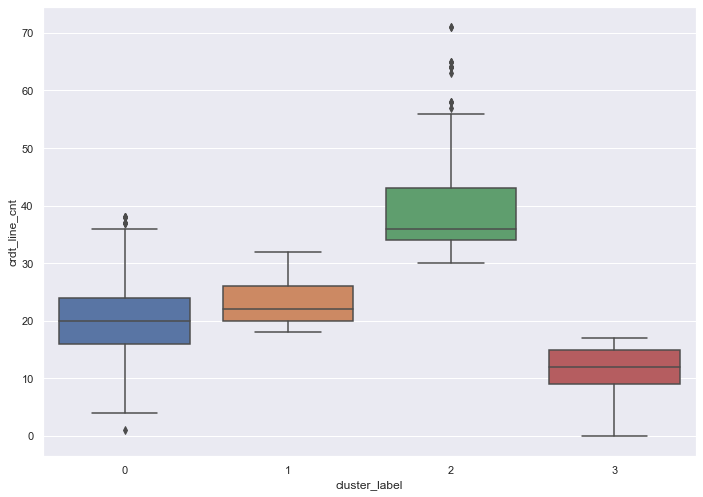

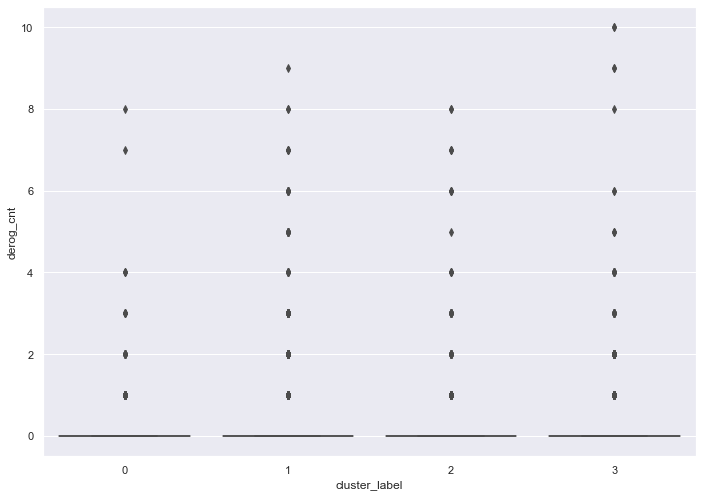

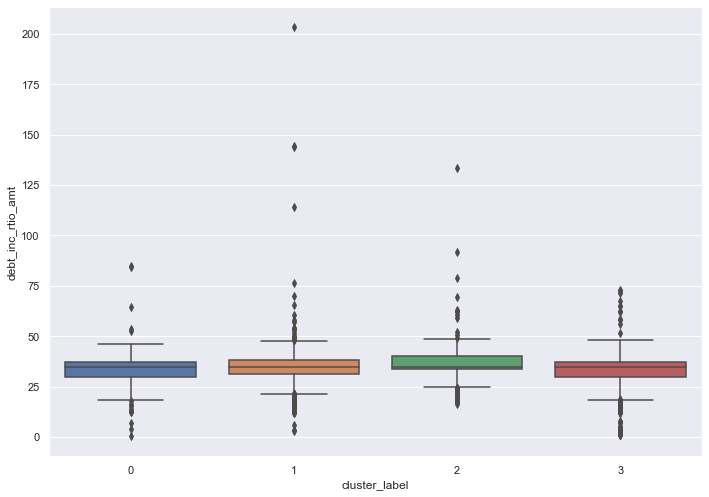

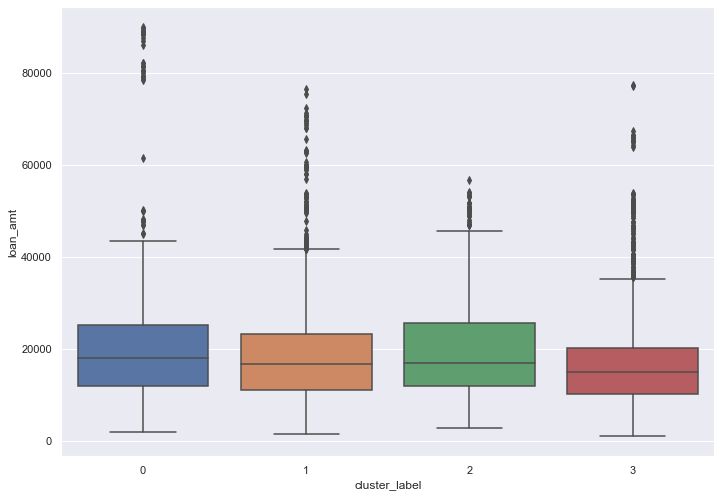

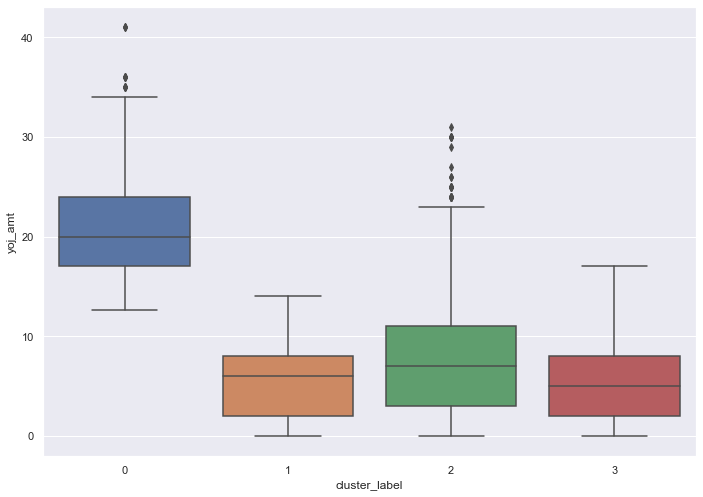

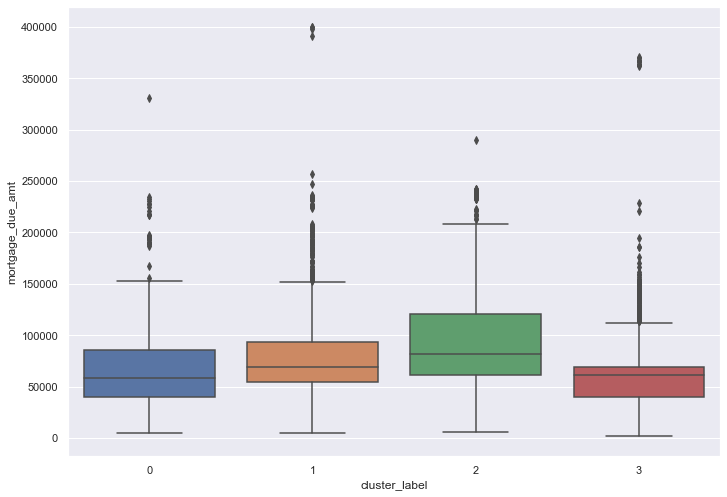

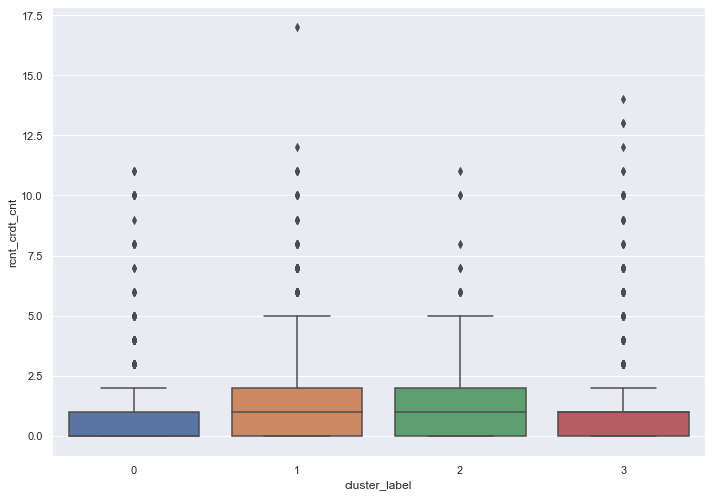

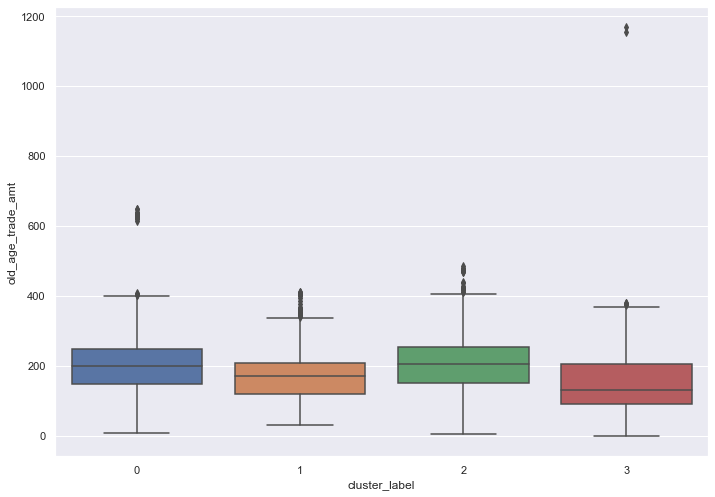

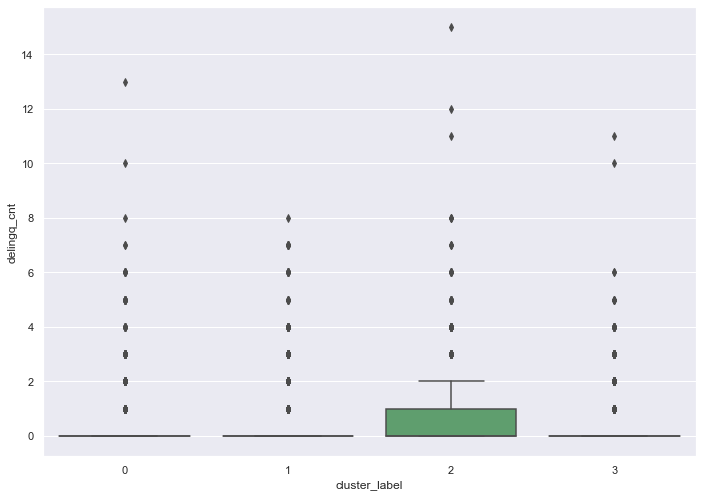

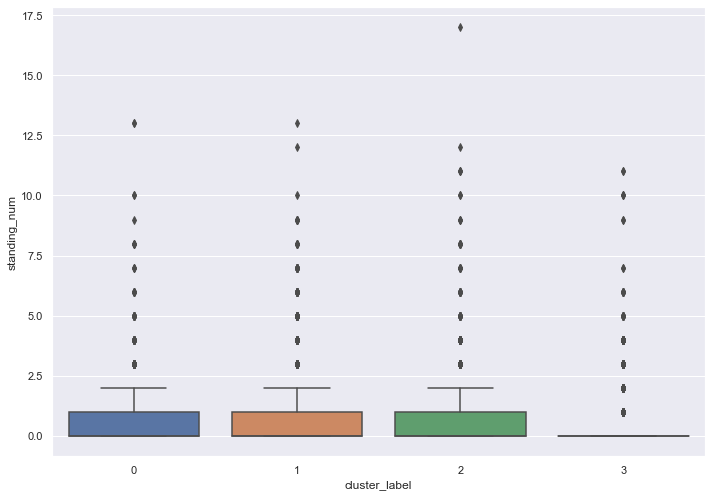

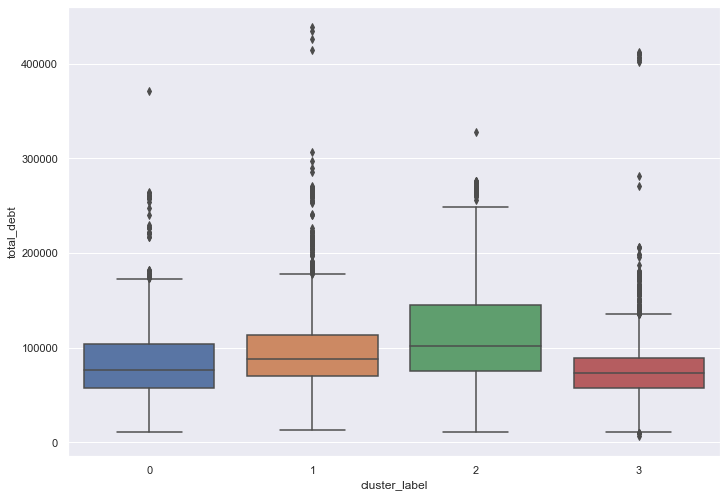

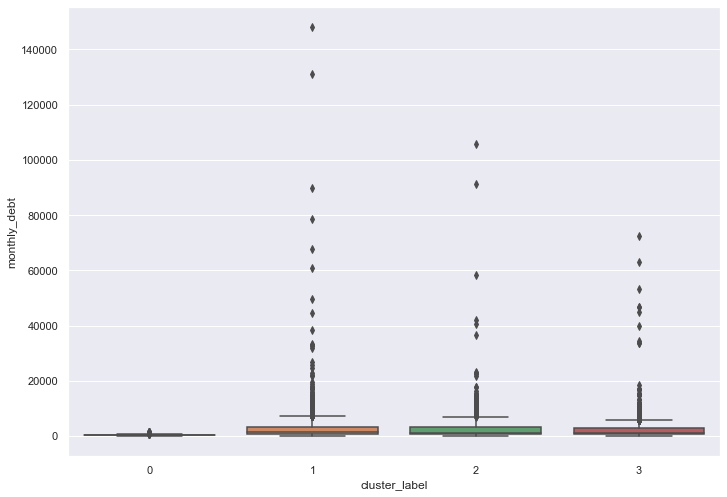

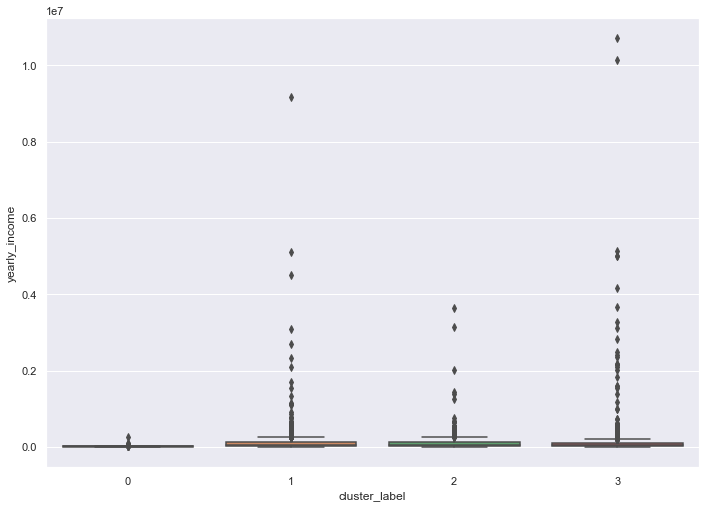

In [83]:
eda_boxplots()

Boxplots are relatively similar to each cluster and are not giving me distinct information about the clusters. So let's group the labels and take a look at the sums.

In [84]:
cluster_.groupby(['cluster_label']).sum()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income
cluster_label,,,,,,,,,,,,,,,,
0,3310551,1.130123e+08,175,22072.0,147.0,37111.212200,22687100,23070.30,7.213530e+07,1112.0,231305.914960,534.0,681.0,9.482240e+07,406212.19,15248997.0
1,6812456,2.418485e+08,418,52211.0,602.0,77601.961100,42022400,12772.15,1.769030e+08,2813.0,388132.074571,800.0,1402.0,2.189254e+08,7055964.63,255092507.0
2,2481589,1.021674e+08,196,32634.0,214.0,30140.190429,16609400,6683.50,8.026636e+07,1174.0,175991.414907,593.0,807.0,9.687576e+07,2637176.01,91324873.0
3,5153224,1.481525e+08,400,19942.0,374.0,57790.516727,29584600,9660.80,1.057815e+08,1875.0,274037.316251,491.0,865.0,1.353661e+08,4278583.81,220757791.0


Cluster 0 has the least amount in every category
Cluster 1 has the most amount in every category
Cluster 2 is similar to cluster 1 but less intense
Cluster 3 is similar to cluster 0 but more intense

This gives us a sense that for customers who are low risk fall under cluster 0 and 3
and those who are high risk fall under 1 and 2

We can use this label as part of our feature engineering and one hot encoding for our supervised model fitting.

### 5) Final Data Cleaning

### 5.1) Joining labels with main dataset

In [90]:
label_join = cluster_[['pkey' , 'cluster_label']]
df3 = pd.merge(df2,label_join, on = 'pkey')

In [87]:
df3.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_label
0,0,11.426332,0,20.0,0.0,3.440639,9.903538,10.0,10.255587,0.0,4.974230,0.0,0.0,10.788102,6.003072,9.682654,1,0,0,0,0,1,0,0,1,0,0,0,1
1,1,11.388982,0,11.0,0.0,3.800368,8.476580,7.0,11.295801,0.0,5.620518,0.0,0.0,11.353730,6.923885,10.235270,0,1,0,0,0,1,0,0,1,0,0,0,3
2,2,12.399182,0,26.0,0.0,3.744246,10.154285,8.0,12.193119,2.0,4.644010,0.0,0.0,12.315492,7.751570,11.120919,1,0,0,0,1,0,0,0,1,0,0,0,1
3,3,11.134604,0,42.0,0.0,3.578458,9.798183,10.0,10.714440,1.0,5.256453,0.0,0.0,11.050906,6.265301,9.803391,1,0,0,0,0,1,0,0,1,0,0,0,2
4,4,10.924156,0,11.0,0.0,3.578458,9.059634,6.0,10.624420,1.0,4.304515,0.0,0.0,10.814303,6.539066,10.077609,1,0,0,0,1,0,0,0,1,0,0,0,3


In [91]:
## replacing numerical values with categorical for our one hot encodings
df3 = df3.rename(columns = {'cluster_label' : 'cluster_group'})
df3['cluster_group'] = df3['cluster_group'].replace([0,1,2,3], ['Lowest Risk', 'Highest Risk' , 'High Risk' , 'Low Risk'])

In [92]:
df3.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_group
0,0,11.426332,0,20.0,0.0,3.440639,9.903538,10.0,10.255587,0.0,4.974230,0.0,0.0,10.788102,6.003072,9.682654,1,0,0,0,0,1,0,0,1,0,0,0,Highest Risk
1,1,11.388982,0,11.0,0.0,3.800368,8.476580,7.0,11.295801,0.0,5.620518,0.0,0.0,11.353730,6.923885,10.235270,0,1,0,0,0,1,0,0,1,0,0,0,Low Risk
2,2,12.399182,0,26.0,0.0,3.744246,10.154285,8.0,12.193119,2.0,4.644010,0.0,0.0,12.315492,7.751570,11.120919,1,0,0,0,1,0,0,0,1,0,0,0,Highest Risk
3,3,11.134604,0,42.0,0.0,3.578458,9.798183,10.0,10.714440,1.0,5.256453,0.0,0.0,11.050906,6.265301,9.803391,1,0,0,0,0,1,0,0,1,0,0,0,High Risk
4,4,10.924156,0,11.0,0.0,3.578458,9.059634,6.0,10.624420,1.0,4.304515,0.0,0.0,10.814303,6.539066,10.077609,1,0,0,0,1,0,0,0,1,0,0,0,Low Risk


In [93]:
df3 = pd.get_dummies(df3)

In [94]:
df3.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_group_High Risk,cluster_group_Highest Risk,cluster_group_Low Risk,cluster_group_Lowest Risk
0,0,11.426332,0,20.0,0.0,3.440639,9.903538,10.0,10.255587,0.0,4.974230,0.0,0.0,10.788102,6.003072,9.682654,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,11.388982,0,11.0,0.0,3.800368,8.476580,7.0,11.295801,0.0,5.620518,0.0,0.0,11.353730,6.923885,10.235270,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,2,12.399182,0,26.0,0.0,3.744246,10.154285,8.0,12.193119,2.0,4.644010,0.0,0.0,12.315492,7.751570,11.120919,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3,3,11.134604,0,42.0,0.0,3.578458,9.798183,10.0,10.714440,1.0,5.256453,0.0,0.0,11.050906,6.265301,9.803391,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
4,4,10.924156,0,11.0,0.0,3.578458,9.059634,6.0,10.624420,1.0,4.304515,0.0,0.0,10.814303,6.539066,10.077609,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


### 5.2) Rebalancing

In [95]:
### Rebalancing the target variable because there is a huge difference in the target variables.

df3.target.value_counts()

0    4771
1    1189
Name: target, dtype: int64

In [96]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df3[df3.target==0]
df_minority = df3[df3.target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4771,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.target.value_counts()

1    4771
0    4771
Name: target, dtype: int64

In [97]:
df_upsampled.head()

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_group_High Risk,cluster_group_Highest Risk,cluster_group_Low Risk,cluster_group_Lowest Risk
0,0,11.426332,0,20.0,0.0,3.440639,9.903538,10.0,10.255587,0.0,4.974230,0.0,0.0,10.788102,6.003072,9.682654,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,11.388982,0,11.0,0.0,3.800368,8.476580,7.0,11.295801,0.0,5.620518,0.0,0.0,11.353730,6.923885,10.235270,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,2,12.399182,0,26.0,0.0,3.744246,10.154285,8.0,12.193119,2.0,4.644010,0.0,0.0,12.315492,7.751570,11.120919,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3,3,11.134604,0,42.0,0.0,3.578458,9.798183,10.0,10.714440,1.0,5.256453,0.0,0.0,11.050906,6.265301,9.803391,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
4,4,10.924156,0,11.0,0.0,3.578458,9.059634,6.0,10.624420,1.0,4.304515,0.0,0.0,10.814303,6.539066,10.077609,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


###  6) Finding the Best Model

In [98]:
## Now that the model ready data set is complete I have to figure out the best model, for that we will use H20

In [99]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\17186\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\17186\AppData\Local\Temp\tmpooda91dw
  JVM stdout: C:\Users\17186\AppData\Local\Temp\tmpooda91dw\h2o_17186_started_from_python.out
  JVM stderr: C:\Users\17186\AppData\Local\Temp\tmpooda91dw\h2o_17186_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_17186_j34bsb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.764 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [100]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_upsampled, test_size = 0.3, random_state=42)

In [101]:
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
x = train.columns
y = 'target'
x.remove(y)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [102]:
aml = H2OAutoML(seed = 42 , sort_metric = 'AUC' , max_models = 30 , max_runtime_secs = 15000 , exclude_algos = ['DeepLearning','StackedEnsemble'])

In [103]:
%%time
aml.train(x = x, y = y , training_frame = train, leaderboard_frame = test)

AutoML progress: |
14:26:25.259: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%
Wall time: 4min 46s


In [105]:
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20210518_142625_model_19,0.997496,0.0591548,0.998004,0.0144244,0.127659,0.0162968
GBM_grid__1_AutoML_20210518_142625_model_12,0.996949,0.0834477,0.997343,0.0189695,0.14912,0.0222369
GBM_grid__1_AutoML_20210518_142625_model_8,0.996855,0.0771574,0.997177,0.0199456,0.146021,0.0213221
DRF_1_AutoML_20210518_142625,0.996703,0.116481,0.997113,0.0206366,0.163364,0.0266878
GBM_grid__1_AutoML_20210518_142625_model_3,0.996691,0.0804191,0.997155,0.017895,0.14386,0.0206958
GBM_4_AutoML_20210518_142625,0.996603,0.0787437,0.997016,0.0175419,0.145776,0.0212506
GBM_grid__1_AutoML_20210518_142625_model_4,0.996529,0.0765297,0.99681,0.0179026,0.144656,0.0209255
GBM_2_AutoML_20210518_142625,0.996497,0.0770018,0.996836,0.0185861,0.144784,0.0209624
GBM_grid__1_AutoML_20210518_142625_model_20,0.996388,0.0754398,0.997109,0.0154989,0.141878,0.0201295
GBM_grid__1_AutoML_20210518_142625_model_14,0.996243,0.0773686,0.996741,0.016528,0.144068,0.0207555


In [106]:
h2o.estimators.xgboost.H2OXGBoostEstimator.available()

Cannot build an XGBoost model - no backend found.


False

In [107]:
## it appears that gradient boosting model is the best bet for the model

In [108]:
df_upsampled.to_csv('model_ready.csv', index = False)